the center of LIS is: ( 653, 113)


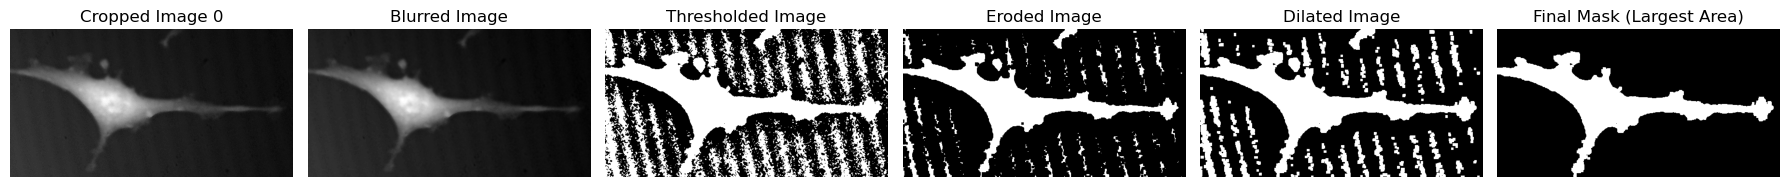

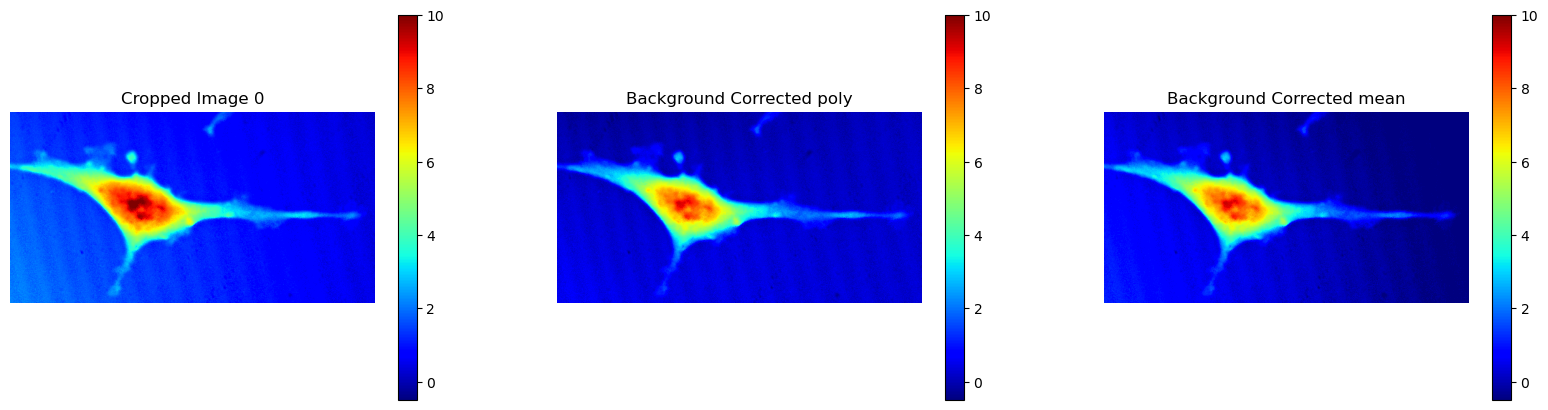

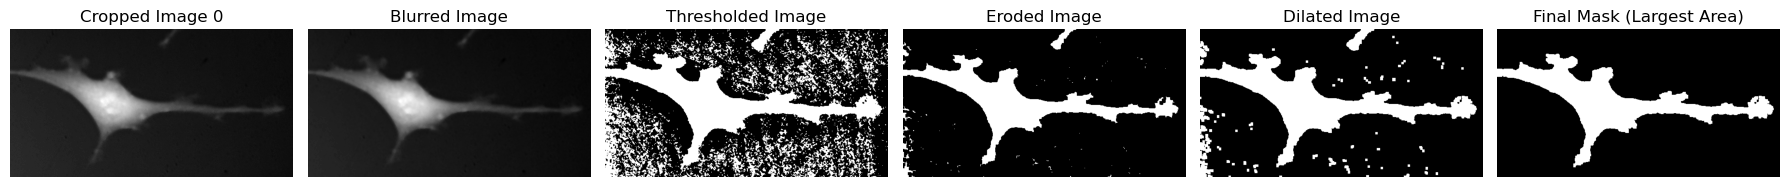

KeyboardInterrupt: 

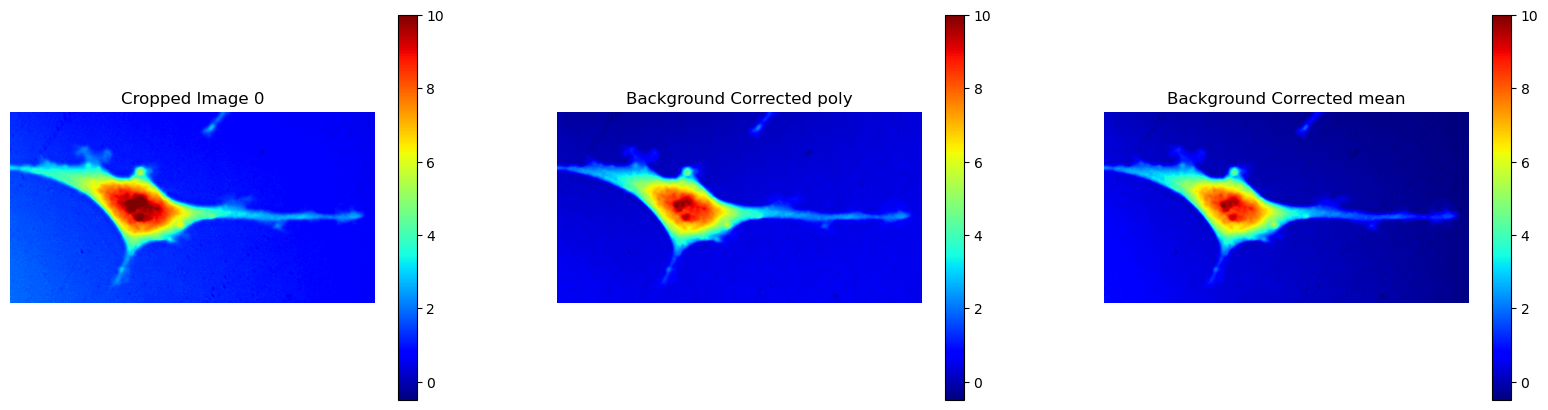

In [48]:
# Required libraries for image processing, data manipulation, and visualization
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy.io as sio
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from skimage import measure, morphology
from skimage.filters import threshold_local
from skimage import img_as_ubyte
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Function to load ROI bounding boxes from CSV
def imcropmatrix_fromcsv(path):
    data = pd.read_csv(path)
    data.columns = data.columns.str.strip()  # Clean column names
    sliceNumbers = data['Slice'].unique()
    Imcropmatrix = np.zeros((len(data) // len(sliceNumbers), 4, len(sliceNumbers)))
    for i, slice_number in enumerate(sliceNumbers):
        sliceData = data[data['Slice'] == slice_number][['BX', 'BY', 'Width', 'Height']].to_numpy()
        Imcropmatrix[:len(sliceData), :, i] = sliceData
    return Imcropmatrix

# Function to load LIScent.tiff and get user click point
def get_LIScent(path):
    LIScent = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
    LISx, LISy = -1, -1  # Initialize click coordinates

    # Callback function for mouse click
    def getLIScent(event, x, y, flag, param):
        global LISx, LISy
        if event == cv2.EVENT_LBUTTONDOWN:
            LISx, LISy = x, y
            print(f'the center of LIS is: ( {x}, {y})')

    cv2.namedWindow('LaserFocus', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('LaserFocus', 800, 500)
    cv2.setMouseCallback('LaserFocus', getLIScent)

    while True:
        cv2.imshow('LaserFocus', LIScent)
        if cv2.waitKey(20) & 0xFF == 27:  # Press Esc to exit
            break

    cv2.destroyAllWindows()
    return [LISx, LISy]

# Load ROI and result data
Imcropmatrix = imcropmatrix_fromcsv('Results220.csv')
get_LIScent("LIScent.tiff")
celldist = np.zeros((Imcropmatrix.shape[0], Imcropmatrix.shape[2]))
weighteddistance = np.zeros((Imcropmatrix.shape[0], Imcropmatrix.shape[2]))
results = sio.loadmat('results220.mat')['results']  # Load MATLAB matrix

alpha = 0.18         # Specific refractive increment
pixel_size = 0.033   # Pixel resolution in microns

# Polynomial background subtraction function
def polynomial_bg_subtraction(image, degree):
    x, y = np.mgrid[:image.shape[0], :image.shape[1]]
    X = np.vstack([x.ravel(), y.ravel()]).T
    Z = image.ravel()
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, Z)
    background = model.predict(X_poly).reshape(image.shape)
    return background

# Load dataset for slice mapping
data = pd.read_csv('Results220.csv')
sliceNumbers = data['Slice'].unique()

m = Imcropmatrix.shape[0]
n = len(sliceNumbers)

# Feature placeholders
cell_features = ['volume', 'voldivarea', 'PA', 'flatness', 'circ', 'SA', 'SAV',
                 'SDM', 'PAV', 'Spherecity', 'HV', 'KT', 'SK', 'Ecc', 'area', 'perimeter']
for feature in cell_features:
    locals()[feature] = np.zeros((m, n))

# Begin main image processing loop
for k in range(m):
    for im in range(n):
        # Compute distance from LIS center to cell center
        celldist[k, im] = np.sqrt((Imcropmatrix[k, 0, im] + Imcropmatrix[k, 2, im] / 2 - LISx) ** 2 +
                                  (Imcropmatrix[k, 1, im] + Imcropmatrix[k, 3, im] / 2 - LISy) ** 2) * pixel_size

        crop_box = tuple(Imcropmatrix[k, :, im].astype(int))  # Get bounding box
        D = results[:, :, im]
        orig_crop = D[crop_box[1]:crop_box[1] + crop_box[3], crop_box[0]:crop_box[0] + crop_box[2]]

        # Normalize the crop to 0-255 and save
        norm_crop = 255 * (orig_crop - orig_crop.min()) / (orig_crop.max() - orig_crop.min())
        norm_crop = norm_crop.astype(np.uint8)
        cv2.imwrite(f'grayim_{im}_{k}.tif', norm_crop)

        # Apply filtering and thresholding
        blurred_image = cv2.medianBlur(norm_crop, 3)
        block_size = 105
        local_thresh = threshold_local(blurred_image, block_size, method='median')
        thresholded_image = blurred_image > local_thresh
        thresholded_image = img_as_ubyte(thresholded_image)

        # Morphological operations
        kernel = np.ones((5, 5), np.uint8)
        eroded_image = cv2.erode(thresholded_image, kernel, iterations=1)
        dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)

        # Label connected components and extract largest object
        labeled_mask = measure.label(dilated_image)
        props = measure.regionprops(labeled_mask)
        areas = [prop.area for prop in props]
        max_area = max(areas)
        max_area_idx = areas.index(max_area)
        final_mask = np.isin(labeled_mask, max_area_idx + 1)

        # Visualization of processing steps
        fig, axes = plt.subplots(1, 6, figsize=(18, 5))
        axes[0].imshow(norm_crop, cmap='gray'); axes[0].set_title(f'Cropped Image {k}'); axes[0].axis('off')
        axes[1].imshow(blurred_image, cmap='gray'); axes[1].set_title('Blurred Image'); axes[1].axis('off')
        axes[2].imshow(thresholded_image, cmap='gray'); axes[2].set_title('Thresholded Image'); axes[2].axis('off')
        axes[3].imshow(eroded_image, cmap='gray'); axes[3].set_title('Eroded Image'); axes[3].axis('off')
        axes[4].imshow(dilated_image, cmap='gray'); axes[4].set_title('Dilated Image'); axes[4].axis('off')
        axes[5].imshow(final_mask, cmap='gray'); axes[5].set_title('Final Mask (Largest Area)'); axes[5].axis('off')
        plt.tight_layout(); plt.show()

        # Polynomial background subtraction using masked background
        only_BG = np.copy(orig_crop)
        only_BG[dilated_image == 0] = 0
        bg = polynomial_bg_subtraction(only_BG, 1)
        bg_corrected_image_poly = orig_crop - bg
        bg_correctedmean = orig_crop - np.mean(orig_crop[dilated_image == 0])

        # Show original vs. corrected images
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        img1 = axes[0].imshow(orig_crop, cmap='jet', vmin=-0.5, vmax=10)
        axes[0].set_title(f'Cropped Image {k}'); axes[0].axis('off'); fig.colorbar(img1, ax=axes[0])

        img2 = axes[1].imshow(bg_corrected_image_poly, cmap='jet', vmin=-0.5, vmax=10)
        axes[1].set_title('Background Corrected poly'); axes[1].axis('off'); fig.colorbar(img2, ax=axes[1])

        img3 = axes[2].imshow(bg_correctedmean, cmap='jet', vmin=-0.5, vmax=10)
        axes[2].set_title('Background Corrected mean'); axes[2].axis('off'); fig.colorbar(img3, ax=axes[2])

        # Calculate height map and volume
        Z = np.zeros_like(bg_correctedmean)
        Z[final_mask == 1] = bg_correctedmean[final_mask == 1]
        volume[k, im] = np.sum(Z) * pixel_size ** 2
        voldivarea[k, im] = volume[k, im] / (np.sum(final_mask) * pixel_size ** 2)
        PA[k, im] = np.sum(final_mask) * pixel_size ** 2

        # Dry mass and OPD
        OPD = Z * 0.033
        drymass = 1 / alpha * np.sum(Z) * pixel_size ** 2 / 1000

        # Placeholder for additional feature calculations
        # Commented out: area, circularity, surface area, eccentricity, kurtosis, skewness, etc.
